# Physics Informed Neural Network (PINN)

In [1]:
# simple demo of PINN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from src.models import Regular_NN, PINN, G
from src.plotting import plot_results, plot_comparison

In [2]:
# set seed for reproducibility
SEED = 86845635 # this seeds shows that boundary condition is important
np.random.seed(SEED)
torch.manual_seed(SEED)

pass

![Football](images/football.png)

We will demo a simple physics-informed neural network (PINN) to model the motion of a free-falling object under gravity. The governing equation is given by Newton's second law:

$\frac{d^2y}{dt^2} = -g$

where $y$ is the position of the object, $t$ is time, and $g$ is the acceleration due to gravity (approximately 9.81 m/s²).
                                                                                                  
Basically, we are modelling a parabola.

We will try three different approaches:
1. Standard Neural Network (NN) without physics constraints.
2. PINN, which includes the physics constraints in the loss function.
3. PINN with added boundary constraints (i.e., initial and final positions).

We will compare the performance of these models in terms of their ability to predict the motion of the falling object.

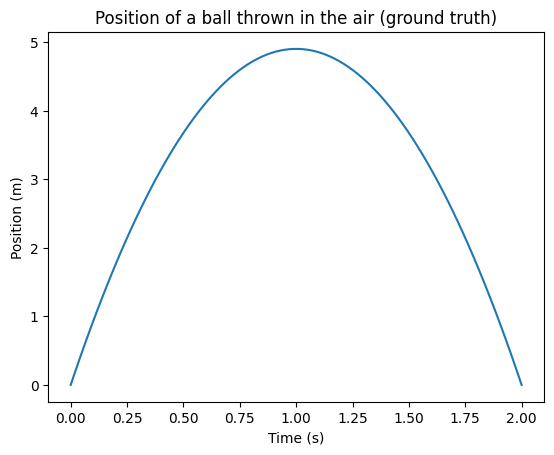

In [3]:
# simple demo of PINN

# first, we create a dataset of a parabola, simulating a ball thrown in the air

def generate_data(num_points=100):
    # time from 0 to 2 seconds
    t = np.linspace(0, 2, num_points)
    # position y = -0.5*G * t^2 + G*t (initial velocity = G, so ball lands at t=2)
    y = -0.5*G * t**2 + G * t
    return t, y

# plot the generated data
t, y = generate_data()
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position of a ball thrown in the air (ground truth)')
plt.show()

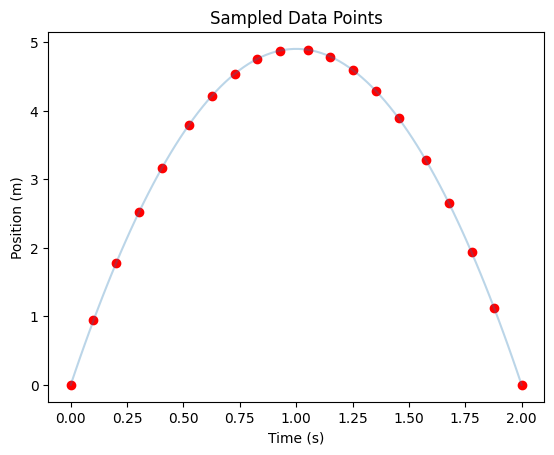

In [4]:
# Let's sample some points from this dataset to train our PINN
def sample_data(t, y, num_samples=20):
    # sample the point evenly over time
    indices = np.linspace(0, len(t)-1, num_samples).astype(int)
    return t[indices], y[indices]

t_samples, y_samples = sample_data(t, y)
plt.scatter(t_samples, y_samples, color='red')
plt.plot(t, y, alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Sampled Data Points')
plt.show()

Now, we add noise to the sampled data to simulate real-world measurements.

Additionally, I added a `add_random_offset` function to further add random offsets to the noisy data points, simulating measurement errors.

With the noisy data, we hypothesise that the classic NN model may end up overfitting the noise and disobeying the physics of the system. 

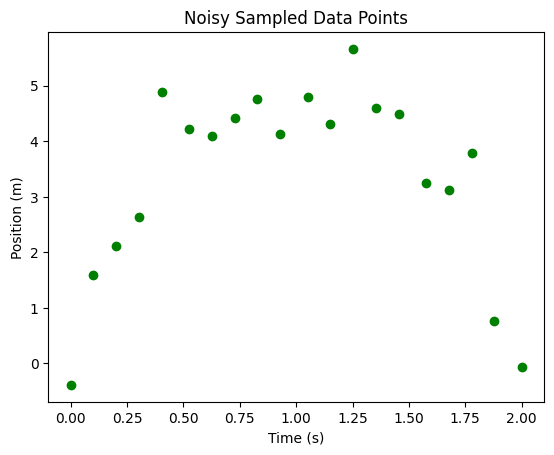

In [5]:
# now, add noise to the data
def add_noise(y, noise_level=0.5):
    noise = noise_level * np.random.randn(*y.shape)
    return y + noise

# also, randomly offset some points, to simulate errors in measurement
def add_random_offsets(y, num_offsets=5, offset_magnitude=3.0):
    indices = np.random.choice(len(y), num_offsets, replace=False)
    for idx in indices:
        y[idx] += offset_magnitude * (2 * np.random.rand() - 1)  # random offset between -magnitude and +magnitude
    return y

y_noisy = add_noise(y_samples)
y_noisy = add_random_offsets(y_noisy, num_offsets=5, offset_magnitude=3.0)
plt.scatter(t_samples, y_noisy, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Noisy Sampled Data Points')
plt.show()

In [6]:
# now, create dataframe of the noisy data, with the ground truth labels

df = pd.DataFrame({
    'time': t_samples,
    'position_noisy': y_noisy,
    'position_true': y_samples
})

df.head()

,time,position_noisy,position_true
0,0.00000,-0.388318,0.000000
1,0.10101,1.597757,0.940863
2,0.20202,2.116477,1.781635
3,0.30303,2.641284,2.522314
4,0.40404,4.888894,3.162902


In [7]:
# prepare tensors for training
t_tensor = torch.tensor(t_samples, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y_noisy, dtype=torch.float32).view(-1, 1)

In [8]:
model = Regular_NN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model

Regular_NN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [9]:
# training loop
history = model.train_model(t_tensor, y_tensor, 
                  criterion, optimizer,
                  num_epochs=1000
                )


Epoch [100/1000], Loss: 0.6942
Epoch [200/1000], Loss: 0.3746
Epoch [300/1000], Loss: 0.3231
Epoch [400/1000], Loss: 0.2932
Epoch [500/1000], Loss: 0.2627
Epoch [600/1000], Loss: 0.2222
Epoch [700/1000], Loss: 0.1800
Epoch [800/1000], Loss: 0.1425
Epoch [900/1000], Loss: 0.1119
Epoch [1000/1000], Loss: 0.0879


In [10]:
# evaluate the model
model.eval()
with torch.no_grad():
    t_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
    y_pred = model(t_test).numpy().flatten()
    

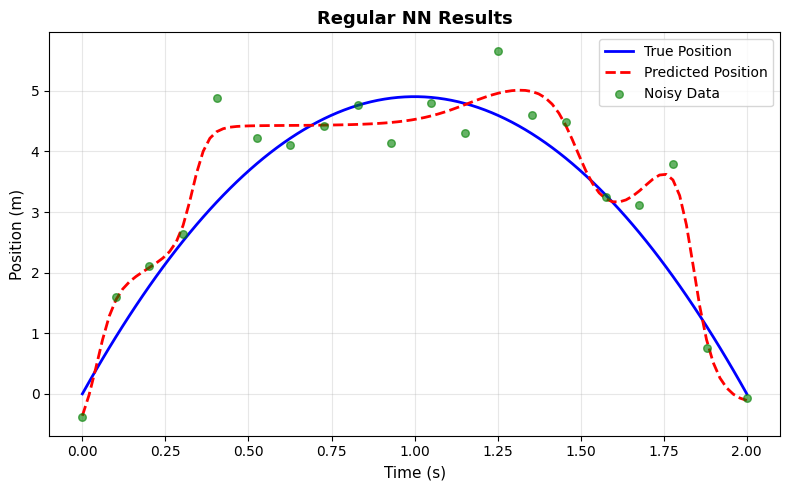

In [11]:
# plot results of regular NN
plot_results(t, y, y_pred, title='Regular NN Results', t_samples=t_samples, y_noisy=y_noisy)

Clearly, we see the regular NN overfitting the noisy data, resulting in a high-order polynomial-like curve.

Now, we add the **Physics Loss** to the loss function of our NN model:

```python
    def physics_loss(self, t):
        # simplified from actual code
        t_ = t.clone()
        y = self.forward(t_) # get predicted position
        dy_dt = torch.autograd.grad(y, t_)[0] # first derivative
        d2y_dt2 = torch.autograd.grad(dy_dt, t_,)[0] # second derivative

        # Physics: d2y/dt2 + g = 0  => d2y/dt2 = -g
        G = 9.81 # gravitational constant
        physics_residual = d2y_dt2 + G
        return torch.mean(physics_residual**2)
```

Recall that our physics equation of gravity is $\frac{d^2y}{dt^2} = -g$. Hence, we want to minimise the difference between the second derivative of our predicted position with respect to time and -g. This is captured in the `physics_loss` function above.

We derive the second derivative using PyTorch's `autograd` functionality to compute gradients (very convenient). Then, we define the physics residual as the difference between the second derivative and -g, and compute the mean squared value of this residual to use as our physics loss. 

Overall, we want to minimise the term $\left(\frac{d^2y}{dt^2} + g\right)^2$.

The error term will be added to the overall loss function, scaled by a `lambda` value, similar to a regularisation term.

`loss = data_loss + lambda * physics_loss`

In [12]:
# declare PINN model
model_pinn = PINN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=0.01)

In [13]:
# training loop for PINN (without boundary constraints)
history = model_pinn.train_model(t_tensor, y_tensor, 
                       criterion, optimizer,
                       num_epochs=1000, 
                       lambda_phys=1, # weight for physics loss
                       lambda_bc=0  # weight for boundary constraints. we set to 0 first
                    )



Epoch [100/1000], Total: 27.687235, data: 13.870407, phys: 13.816828, bc: 82.183716
Epoch [200/1000], Total: 25.806154, data: 14.553621, phys: 11.252533, bc: 84.551178
Epoch [300/1000], Total: 25.715847, data: 14.594978, phys: 11.120870, bc: 84.673088
Epoch [400/1000], Total: 25.512918, data: 14.849495, phys: 10.663424, bc: 85.929527
Epoch [500/1000], Total: 24.733149, data: 14.412767, phys: 10.320381, bc: 83.697540
Epoch [600/1000], Total: 23.218313, data: 12.821790, phys: 10.396523, bc: 76.039963
Epoch [700/1000], Total: 22.294918, data: 12.541283, phys: 9.753634, bc: 75.154915
Epoch [800/1000], Total: 20.882490, data: 12.119525, phys: 8.762965, bc: 72.843369
Epoch [900/1000], Total: 19.287949, data: 12.840639, phys: 6.447309, bc: 77.100662
Epoch [1000/1000], Total: 17.643890, data: 10.769529, phys: 6.874360, bc: 65.664360


In [14]:
# evaluate the model
model_pinn.eval()
with torch.no_grad():
    t_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
    y_pred_pinn = model_pinn(t_test).numpy().flatten()


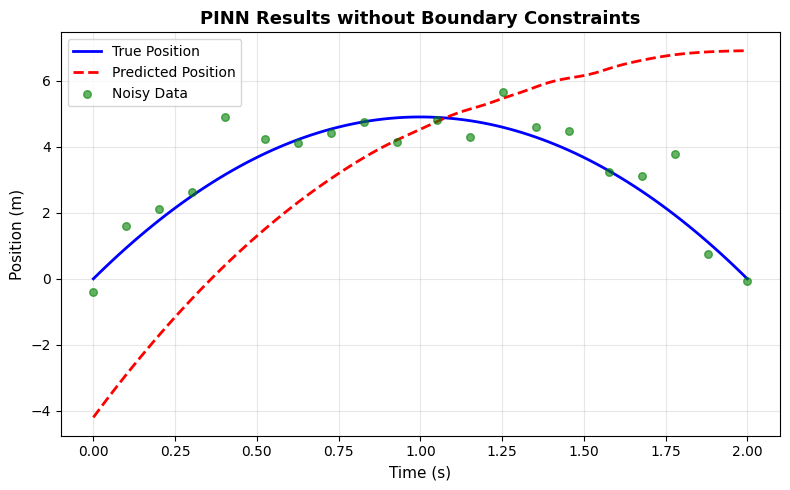

In [15]:
# plot results of PINN 
plot_results(t, y, y_pred_pinn, title='PINN Results without Boundary Constraints', t_samples=t_samples, y_noisy=y_noisy)

With the physics loss added, we see that the model is coerced to predict a parabolic trajectory. However, given how noisy the data is, the starting and end points of the curve are off, with the curve starting underground and ending above ground, without landing.

To solve the boundary condition issue, we add the boundary constraints to the PINN training.

```python
    def bc_loss(self, t_start, t_end, y_start=0.0, y_end=0.0):
        # enforce y(t_start)=y_start and y(t_end)=y_end
        t0 = torch.tensor([[float(t_start)]], dtype=torch.float32)
        tT = torch.tensor([[float(t_end)]], dtype=torch.float32)
        y0 = self.forward(t0)
        yT = self.forward(tT)

        # compute MSE loss for boundary conditions
        # equation: (y(t_start) - y_start)^2 + (y(t_end) - y_end)^2
        return torch.mean((y0 - float(y_start))**2) + torch.mean((yT - float(y_end))**2)
```

This loss term essentially minimises the squared difference between the predicted and expected positions at the start and end times, shown by this equation: $(y(t_{start}) - y_{start})^2 + (y(t_{end}) - y_{end})^2$.

In our case, our boundary conditions at time t=0s and t=2s are both y=0m (the ball starts and ends at ground level). Therefore, we are minimising the equation: $(y(0) - 0)^2 + (y(2) - 0)^2$.

In [16]:
# now, train with boundary constraints enabled
model_pinn_bc = PINN()
optimizer = torch.optim.Adam(model_pinn_bc.parameters(), lr=0.01)
criterion = nn.MSELoss()


In [17]:
history = model_pinn_bc.train_model(t_tensor, y_tensor, 
                         criterion, optimizer,
                         num_epochs=1000, 
                         lambda_phys=1, # weight for physics loss
                         lambda_bc=10  # weight for boundary constraints
                        )

Epoch [100/1000], Total: 0.718126, data: 0.506434, phys: 0.209567, bc: 0.000212
Epoch [200/1000], Total: 0.686463, data: 0.531941, phys: 0.031417, bc: 0.012310
Epoch [300/1000], Total: 0.503011, data: 0.490527, phys: 0.009979, bc: 0.000250
Epoch [400/1000], Total: 0.500860, data: 0.492118, phys: 0.007802, bc: 0.000094
Epoch [500/1000], Total: 0.504368, data: 0.484976, phys: 0.005418, bc: 0.001397
Epoch [600/1000], Total: 0.498923, data: 0.490086, phys: 0.006149, bc: 0.000269
Epoch [700/1000], Total: 0.499338, data: 0.492564, phys: 0.006005, bc: 0.000077
Epoch [800/1000], Total: 0.498427, data: 0.490164, phys: 0.005674, bc: 0.000259
Epoch [900/1000], Total: 0.499448, data: 0.487501, phys: 0.005150, bc: 0.000680
Epoch [1000/1000], Total: 0.498153, data: 0.490202, phys: 0.005419, bc: 0.000253


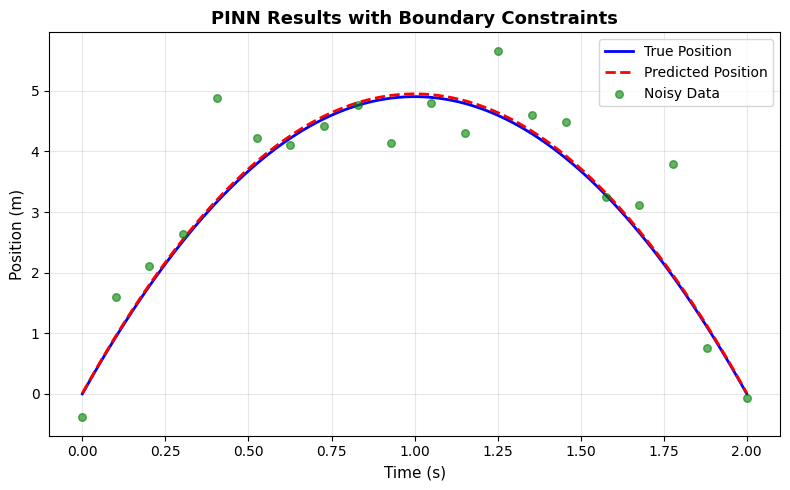

In [18]:
model_pinn_bc.eval()
with torch.no_grad():
    t_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
    y_pred_pinn_bc = model_pinn_bc(t_test).numpy().flatten()

# plot results of PINN with boundary constraints
plot_results(t, y, y_pred_pinn_bc, title='PINN Results with Boundary Constraints', t_samples=t_samples, y_noisy=y_noisy)

Now, with the boundary conditions added, the PINN has managed to confine the start and end points to the ground level (y=0), along with a parabolic path (order 2 curve), which is consistent with the physics of projectile motion under gravity.

# Summary

Physics phenomenon modelled: 
- Ball thrown in the air under gravity.

Physics equation used: 
- $\frac{d^2 y}{dt^2} = -G$ where G is gravitational acceleration.

Boundary conditions used: 
- $y(0) = 0$  and $y(2) = 0$ (the ball returns to ground level after 2 seconds).

Physics Loss Objective: 
- $min ||d^2y/dt^2 + G||^2$

Boundary Condition Loss Objective: 
- $min (||y(0) - 0||^2 + ||y(2) - 0||^2)$

Physics loss can be thought like a regularisation term that pushes the model to respect the underlying physical laws, preventing overfitting to noisy data.

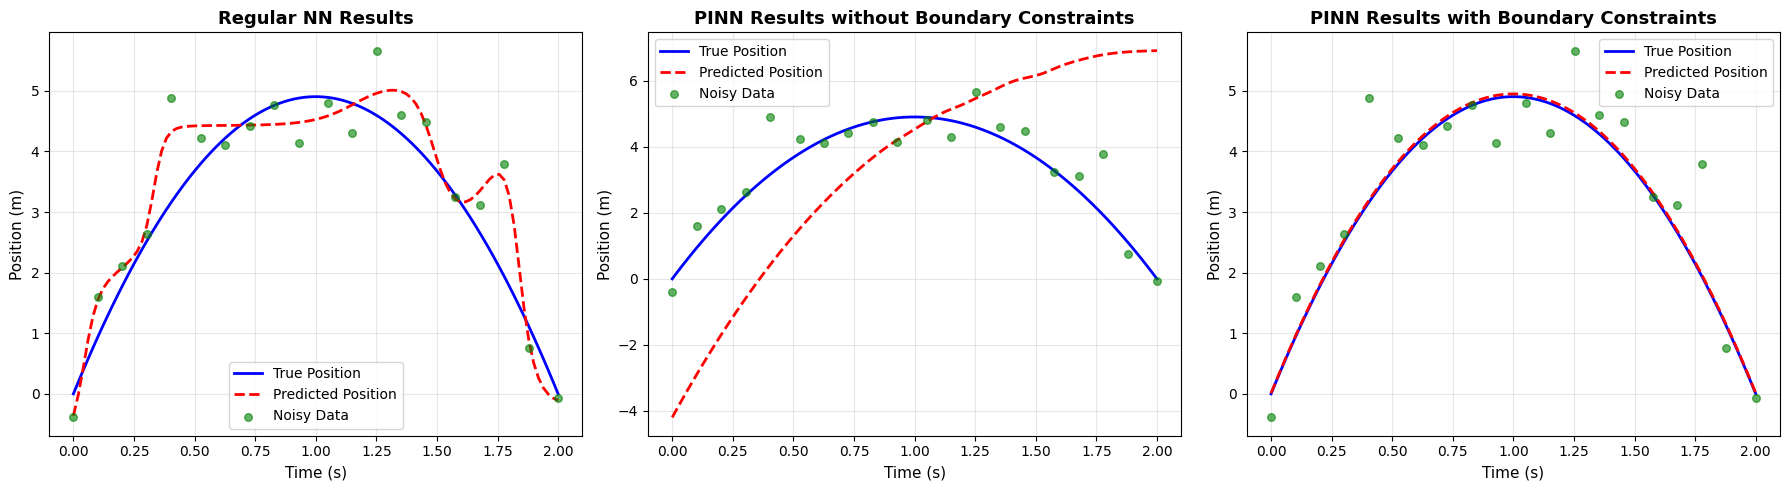

In [19]:
# Side-by-side comparison of all three approaches
plot_comparison(
    t, y,
    predictions=[y_pred, y_pred_pinn, y_pred_pinn_bc],
    titles=['Regular NN Results', 
            'PINN Results without Boundary Constraints', 
            'PINN Results with Boundary Constraints'],
    t_samples=t_samples,
    y_noisy=y_noisy
)

## Caveat

Of course, the demo is quite simple (parabolas are well-understood physics), and hence using PINNs would be an overkill (especially with a network of 2 layers of 20 neurons for a problem for a 2nd-order problem). 

In real-world scenarios, PINNs can be applied to much more complex systems where traditional methods struggle, such as fluid dynamics, material science, and biological systems. The key advantage of PINNs is their ability to incorporate physical laws directly into the learning process, leading to models that not only fit the data but also respect the underlying physics.
